# Code Notebook 4: Transformation, Regression, and Conclusions #

In this notebook, the carefully chosen and prepared features undergo transformatting and fitting.  A gridsearch was used early in the process to aid in model selection.  Three of the most successful and promising models are presented, and then the results of the modelling process are summarized and analyzed, and recommendation made.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
train = pd.read_csv('../datasets/train_2.csv', keep_default_na=False, na_values='null')
# In Part 4, I refer to the test data as "unseen" to distinguish it from any subsets of train I reserve for cross-validation or train/test/split.
unseen = pd.read_csv('../datasets/test_2.csv', keep_default_na=False, na_values='null')

## XII. Transformation, Regression, and Metrics ##

In [3]:
# Prepare the X and y data for fitting, including train/test/split.

X_unseen = unseen.drop('id', axis=1)

X = train.drop(['id', 'saleprice'], axis=1)
y = train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=23748)

In [4]:
# Instantiate the transformers and regression algorithms that will be used.

sc = StandardScaler()
poly = PolynomialFeatures()
linreg = LinearRegression()
ridge = RidgeCV(cv=10)
lasso = LassoCV(cv=10, max_iter=50_000)

# Create a pipeline to experiment with different settings of the transformers and regression algorithms.
# Whichever algorithms weren't were being used were commented out.

pipe = Pipeline([
    ('sc', sc),
    ('poly', poly),
#     ('linreg', linreg),
#     ('ridge', ridge),
    ('lasso', lasso)
])

# Set different transformer parameters to try in the pipeline.

pipe_params = {
    'poly__degree' : [1, 2, 3],
    'poly__include_bias' : [True, False],
    'poly__interaction_only' : [True, False]
}

gs = GridSearchCV(pipe, pipe_params, cv=10)

gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('lasso',
                                        LassoCV(cv=10, max_iter=50000))]),
             param_grid={'poly__degree': [1, 2, 3],
                         'poly__include_bias': [True, False],
                         'poly__interaction_only': [True, False]})

Note: The gridsearch above was primarily used to test different PolyNomial Features settings with LinearRegression, RidgeCV, and LassoCV.  I did experiment with different settings for alpha, particularly with LassoCV, but found only incremental improvement over the default alpha setting.

In [5]:
gs.best_params_

{'poly__degree': 3, 'poly__include_bias': True, 'poly__interaction_only': True}

In [6]:
gs.best_score_

0.8844419552956391

In [7]:
gs.score(X_train, y_train)

0.9215108062218212

In [8]:
gs.score(X_test, y_test)

0.9071358571869942

In [9]:
mean_squared_error(y_test, gs.predict(X_test))**0.5

24129.455887745815

The above gridsearch was used to test different settings of polynomial features with LinearRegression(), RidgeCV(), and LassoCV().  The difference was not very large between LinearRegression(), RidgeCV(), and LassoCV(), but LassoCV() with poly order 3, include bias True, and interaction only True won out.  However, I experimented manually below, and found that poly order 3 seemed overfit when I tried it on the test split.  I settled on poly order 2 as giving somewhat better and more interpretable results.  All of these differences were small in terms of both R2 score and RMSE.

#### Model 1: Top Kaggle Score on 20% of Unseen Data ####

In [10]:
def transform_and_fit(df_train, df_test, vec_train):
    
    """
    Performs the tranformation and fit on the train data.
    Returns the transformed data and fitted regression and polynomial features objects for analysis.
    """
    
    sc = StandardScaler()
    poly = PolynomialFeatures(degree=3)

    df_train_sc = sc.fit_transform(df_train)
    df_test_sc = sc.transform(df_test)

    df_train_sc_poly = poly.fit_transform(df_train_sc)
    df_test_sc_poly = poly.transform(df_test_sc)

    lasso = LassoCV(cv=10)
    lasso.fit(df_train_sc_poly, vec_train);
    
    return lasso, poly, df_train_sc_poly, df_test_sc_poly

In [11]:
def check_metrics(df_train, df_test, vec_train, vec_test):

    """
    Calls transform_and_fit to obtain transformed data and fitted regression and polynomial features object.
    Calculates and prints metrics for analysis.
    """
    
    lasso, poly, df_train_sc_poly, df_test_sc_poly = transform_and_fit(df_train, df_test, vec_train)
    
    print('lasso.alpha_ = ', lasso.alpha_)
    print('train score = ', lasso.score(df_train_sc_poly, vec_train))
    print('test score = ', lasso.score(df_test_sc_poly, vec_test))
    print('RMSE = ', mean_squared_error(vec_test, lasso.predict(df_test_sc_poly))**0.5)
    
    return lasso, poly, df_train_sc_poly, df_test_sc_poly

In [12]:
def prep_submission(df_train, df_test, vec_train):
    
    """
    Applies chosen algorithm to the full set of data, train and test, to gain the benefit of the full set of provided data.
    Prints R2 and then returns predictions for submission to Kaggle competition.
    """
    
    lasso, poly, df_train_sc_poly, df_test_sc_poly = transform_and_fit(df_train, df_test, vec_train)
    
    print('lasso.alpha_ = ', lasso.alpha_)
    print('train score = ', lasso.score(df_train_sc_poly, vec_train))
    
    return lasso.predict(df_test_sc_poly)

In [13]:
lasso_poly3_sc, poly3_sc, poly3_sc_train, poly3_sc_test  = check_metrics(X_train, X_test, y_train, y_test)

lasso.alpha_ =  752.2460876094043
train score =  0.9277456785801956
test score =  0.9003787535295628
RMSE =  24991.91224987597


In [14]:
unseen['saleprice'] = prep_submission(X, X_unseen, y)
unseen[['id', 'saleprice']].to_csv('../datasets/sub18.csv', index=False)

lasso.alpha_ =  1178.127445558155
train score =  0.9219067153119538


Model 1 provided my best-scoring submission to Kaggle based on 20% of the unseen data.  It used PolynomialFeatures() with degree 3, and it yielded an RMSE of \\$20698.47 on Kaggle.  However, I believe that using PolynomialFeatures() degree 2 and keeping all else the same is actually the better model.  Notice that Polynomial degree 3 is somewhat overfit, with a drop in R2 score of over 2% from train to test and an RMSE of \\$24991.91 on my own test data, obtained via train/test/split.  It's worth noting that the unseen data on Kaggle is only 878 rows, and only 20% of that was used to obtain the above score, leaving about 176 rows.  On the other hand, my own test set from train/test/split had 613 rows.  It is true that I was able to remove outliers before train/test/split, and it is possible that higher-order polynomials are better able to account for outliers, causing the better Kaggle score.  However, the usefulness of fitting to outliers is highly situational and would require identifying specific, repeatable, and generalizeable patterns in those outliers.  The outliers I removed were far too few for such analysis.

#### Model 2: Strong Prediction and a Little Underfit ####

In [15]:
def transform_and_fit(df_train, df_test, vec_train):
    
    """
    Performs the tranformation and fit on the train data.
    Returns the transformed data and fitted regression and polynomial features objects for analysis.
    """
    
    sc = StandardScaler()
    poly = PolynomialFeatures(degree=2)

    df_train_sc = sc.fit_transform(df_train)
    df_test_sc = sc.transform(df_test)

    df_train_sc_poly = poly.fit_transform(df_train_sc)
    df_test_sc_poly = poly.transform(df_test_sc)

    lasso = LassoCV(cv=10)
    lasso.fit(df_train_sc_poly, vec_train);
    
    return lasso, poly, df_train_sc_poly, df_test_sc_poly

In [16]:
lasso_poly2_sc, poly2_sc, poly2_sc_train, poly2_sc_test = check_metrics(X_train, X_test, y_train, y_test)

lasso.alpha_ =  903.6587664501424
train score =  0.903252324928213
test score =  0.9193197116308338
RMSE =  22490.92009144679


The only change from Model 1 to Model 2 is that Model 2 has PolynomialFeatures() set at 2, rather than 3.  Notice that Model 2 actually features an increase in RMSE of nearly 2% from train to test, suggesting that it is slighlty underfit and should be quite consistent when applied to new data.  The RMSE on my test split improved to \\$22490.92, vs. \\$24991.91 for Model 1, even though Model 2 scored worse on the 20% of unseen data in Kaggle.

#### Model 3: No Scaling or Regularization ####

In [17]:
def transform_and_fit(df_train, df_test, vec_train):
    
    """
    Performs the tranformation and fit on the train data.
    Returns the transformed data and fitted regression and polynomial features objects for analysis.
    """
    
    poly = PolynomialFeatures(degree=2)

    df_train_poly = poly.fit_transform(df_train)
    df_test_poly = poly.transform(df_test)

    linreg = LinearRegression()
    linreg.fit(df_train_poly, vec_train);
    
    return linreg, poly, df_train_poly, df_test_poly

In [18]:
def check_metrics(df_train, df_test, vec_train, vec_test):
    
    """
    Calls transform_and_fit to obtain transformed data and fitted regression and polynomial features object.
    Calculates and prints metrics for analysis.
    """
    
    linreg, poly, df_train_poly, df_test_poly = transform_and_fit(df_train, df_test, vec_train)
    
    print('train score = ', linreg.score(df_train_poly, vec_train))
    print('test score = ', linreg.score(df_test_poly, vec_test))
    print('RMSE = ', mean_squared_error(vec_test, linreg.predict(df_test_poly))**0.5)
    
    return linreg, poly, df_train_poly, df_test_poly

In [19]:
linreg_poly2, poly2, poly2_train, poly2_test = check_metrics(X_train, X_test, y_train, y_test)

train score =  0.9126536671607142
test score =  0.9095116763461353
RMSE =  23818.794254445842


Model 3 removes StandardScaler and Lasso from Model 2 with the intent of improving interpretability.  Removing Lasso also means removing the built-in cross-validation, as the linear regression method used in Model 3 does not apply cross-validation while fitting.  Notice that very little is sacrificed in this process.  Model 3 appears to be slightly overfit, as opposed to the underfit Model 2, and has an RMSE on the test split between that of Model 1 and Model 2.  It appears that the regularization in Model 2 was helpful, but the model was not too badly overfit in the first place, so Model 3 still performs well without regularization.  Since the only difference Models 2 and 3 is StandardScaler and Lasso, they can be compared effectively during analysis.

## XIII. Analysis and Conclusions ##

For the reasons discussed above, I will not include Model 1 in this analysis.  Below, I created a DataFrame of both models that used polynomial features up to order 2.

As a reminder, our baseline model was based on the naive prediction that each sale price would be equal to the average sale price.  This assumption is incorporated into R2 as the baseline model by default.  Below, I have shown that the root mean square error that model produces when applied to the test set of my train/test split is about \\$79,181.46.

For comparison, the root mean square errors of the models I will be discussing are \\$22,490.92 (with lasso) and \\$23,818.79 (without lasso).  The R2 scores for both models were between 0.90 and 0.92, indicating that they accounted for about 90\% - 92\% of the price variability not accounted for by the naive baseline model.  The R2 scores suggest that these models capture the majority of important features.  Improvement beyond this point would be quite difficult, considering that an R2 score of 1 would would require that every sale price be predicted perfectly.  The root mean square errors tell us that a guess based on the naive baseline model will, on average, miss the true price by about three times as much as a guess based on these regression models.

Overall, we can say that these models make significant improvements on guessing house price based on the local average price.  Below, I will further investigate specific strengths and shortcomings of the models, as well as what they can tell us about the major factors that influence housing price.

In [20]:
# Calculating RMSE using naive model of average home price for the purpose of comparison.

naive_model = pd.DataFrame(y_test)
naive_model['y_mean'] = y_test.mean()
mean_squared_error(naive_model['saleprice'], naive_model['y_mean'])**0.5

79181.45933464052

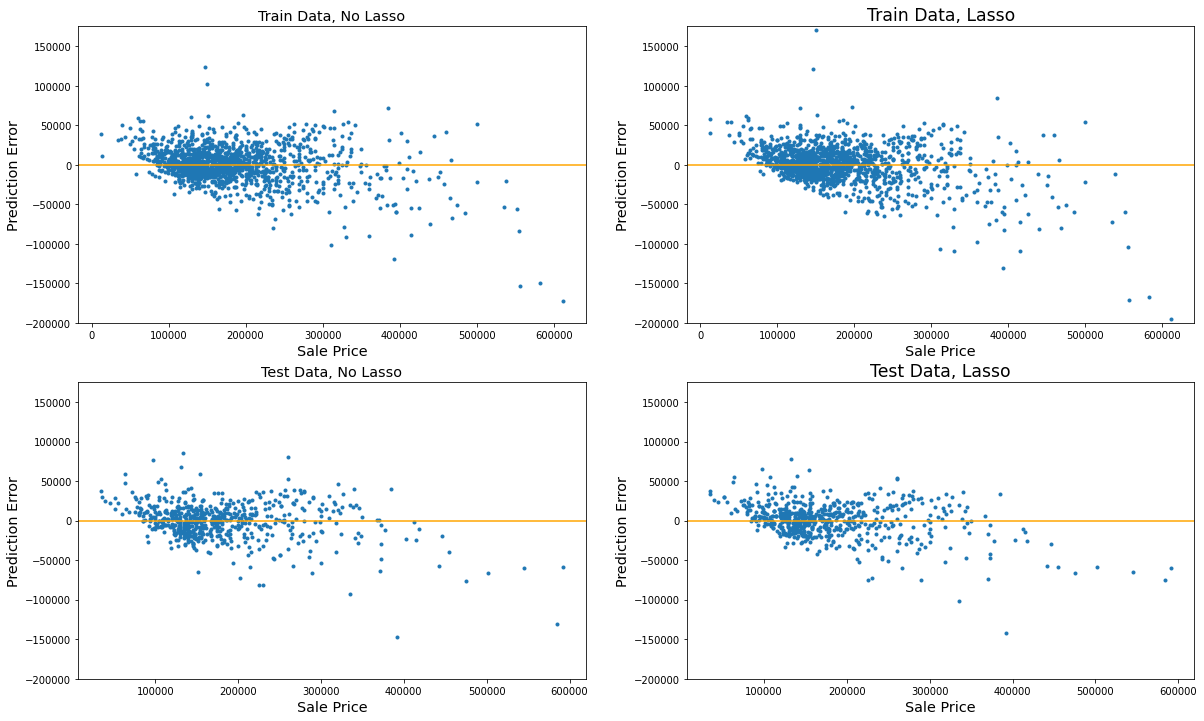

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20,12), gridspec_kw={'hspace' : .2})

axs[0,0].scatter(y_train, (linreg_poly2.predict(poly2_train) - y_train), marker='.')
axs[0,0].set_xlabel('Sale Price', fontsize='x-large')
axs[0,0].set_ylabel('Prediction Error', fontsize='x-large')
axs[0,0].set_title('Train Data, No Lasso', fontsize='x-large')
axs[0,0].set_ylim(-200_000, 175_000)
axs[0,0].axhline(y=0, color='orange')

axs[1,0].scatter(y_test, (linreg_poly2.predict(poly2_test) - y_test), marker='.')
axs[1,0].set_xlabel('Sale Price', fontsize='x-large')
axs[1,0].set_ylabel('Prediction Error', fontsize='x-large')
axs[1,0].set_title('Test Data, No Lasso', fontsize='x-large')
axs[1,0].set_ylim(-200_000, 175_000)
axs[1,0].axhline(y=0, color='orange')

axs[0,1].scatter(y_train, (lasso_poly2_sc.predict(poly2_sc_train) - y_train), marker='.')
axs[0,1].set_xlabel('Sale Price', fontsize='x-large')
axs[0,1].set_ylabel('Prediction Error', fontsize='x-large')
axs[0,1].set_title('Train Data, Lasso', fontsize='xx-large')
axs[0,1].set_ylim(-200_000, 175_000)
axs[0,1].axhline(y=0, color='orange')

axs[1,1].scatter(y_test, (lasso_poly2_sc.predict(poly2_sc_test) - y_test), marker='.')
axs[1,1].set_xlabel('Sale Price', fontsize='x-large')
axs[1,1].set_ylabel('Prediction Error', fontsize='x-large')
axs[1,1].set_title('Test Data, Lasso', fontsize='xx-large')
axs[1,1].set_ylim(-200_000, 175_000)
axs[1,1].axhline(y=0, color='orange');

The above are residual plots of each model's performance on both the training data and the testing data from train/test split.

The models had very similar distributions of residuals.  They tended to overestimate low prices and underestimate high prices.  It's interesting that neither model was able to correct for that pattern.  This is likely because the low and high values represented a small portion of the sales.  Residuals for the main cluster of sales between \\$100,000 and \\$200,000 look very symmetrical.  Inclusion of more specialized features may improve the ability of the model to capture the features at very high or low prices.

Residual distribution on train and test was quite similar for both models.  Along with the similar R2 scores between train and test data, this suggests little or no systematic error generalizing to new data.  These models should perform quite well on new data, within the limitation of how well the Ames Housing data can be generalized to other housing markets.  This question would require analysis of a broader dataset, but it will be discussed below when considering important features in the models.

In [22]:
# Save coefficients from chosen models in a DataFrame along with feature names for each coeffiencient.

fit_coefs = pd.DataFrame(zip(poly2.get_feature_names(X.columns), linreg_poly2.coef_, lasso_poly2_sc.coef_),
             columns=['Feature', 'Linreg_coef', 'Lasso_poly2_coef'])

In [23]:
# Sort DataFrame by coefficient size for each of the two fits and reset index to that the DataFrames with each ordering can be merged.

fit_coefs_bylin = fit_coefs.sort_values(by='Linreg_coef', ascending=False)
fit_coefs_bylin.reset_index(drop=True, inplace=True)
fit_coefs_bylasso = fit_coefs.sort_values(by='Lasso_poly2_coef', ascending=False)
fit_coefs_bylasso.reset_index(drop=True, inplace=True)

In [24]:
# Rename columns to clarify that each set of columns has the same information but has been sorted differently.

fit_coefs_bylin.rename(mapper={
    'Feature' : 'Feature_bylin',
    'Linreg_coef' : 'Linreg_coef_bylin',
    'Lasso_poly2_coef' : 'Lasso_poly2_coef_bylin'}, axis=1, inplace=True)

fit_coefs_bylasso.rename(mapper={
    'Feature' : 'Feature_bylasso',
    'Linreg_coef' : 'Linreg_coef_bylasso',
    'Lasso_poly2_coef' : 'Lasso_poly2_coef_bylasso'}, axis=1, inplace=True)

In [25]:
# Combine the two sorted DataFrames into one for side-by-side comparion of the top features according to each model.

fit_compare_coef = pd.concat([fit_coefs_bylin, fit_coefs_bylasso], axis=1)

In [26]:
fit_compare_coef.head(20)

,Feature_bylin,Linreg_coef_bylin,Lasso_poly2_coef_bylin,Feature_bylasso,Linreg_coef_bylasso,Lasso_poly2_coef_bylasso
0,neighborhood,27755.134086,5051.378575,overall_qual,-3860.534910,23650.474291
1,heating_qc,16270.958938,3066.887886,gr_liv_area,-6.760608,19271.633275
2,half_bath,12479.689960,0.000000,year_built,-133.934458,9804.052624
3,half_bath neighborhood,11312.841177,1201.541941,garage_total,-0.444776,8686.060400
4,neighborhood overall_qual,3449.533656,0.000000,lot_area,-5.124621,8497.107342
5,overall_qual fireplace_qu,1238.686835,1121.298301,bsmt_total,-12.725194,7861.070075
6,half_bath heating_qc,763.569692,-0.000000,fireplace_qu,-12541.230952,5885.083504
7,neighborhood fireplace_qu,669.642101,0.000000,neighborhood,27755.134086,5051.378575
8,overall_qual^2,471.801030,0.000000,overall_qual garage_total,0.056068,3775.213957
9,neighborhood year_built,345.152210,0.000000,porch_space,6.275120,3722.538448


In [27]:
fit_compare_coef.tail(10)[::-1]

,Feature_bylin,Linreg_coef_bylin,Lasso_poly2_coef_bylin,Feature_bylasso,Linreg_coef_bylasso,Lasso_poly2_coef_bylasso
90,neighborhood^2,-18521.503973,-599.448747,half_bath year_built,-198.433072,-1593.045971
89,half_bath^2,-12725.679616,-1546.340732,half_bath^2,-12725.679616,-1546.340732
88,fireplace_qu,-12541.230952,5885.083504,heating_qc year_built,-101.862923,-855.044819
87,neighborhood heating_qc,-4965.543493,-208.767938,lot_area mas_vnr_area,-0.003087,-787.439426
86,overall_qual,-3860.534910,23650.474291,neighborhood^2,-18521.503973,-599.448747
85,half_bath fireplace_qu,-1650.965444,-34.680590,lot_area^2,-0.000023,-238.098767
84,overall_qual heating_qc,-846.649369,-0.000000,garage_total bsmt_total,-0.000208,-214.669358
83,half_bath year_built,-198.433072,-1593.045971,neighborhood heating_qc,-4965.543493,-208.767938
82,year_built,-133.934458,9804.052624,porch_space^2,-0.038417,-185.489918
81,half_bath overall_qual,-124.220903,-0.000000,heating_qc^2,-1.625848,-93.033268


In [28]:
train.columns

Index(['saleprice', 'id', 'half_bath', 'gr_liv_area', 'lot_area',
       'neighborhood', 'overall_qual', 'fireplace_qu', 'heating_qc',
       'mas_vnr_area', 'year_built', 'porch_space', 'garage_total',
       'bsmt_total'],
      dtype='object')

The left 3 columns show the features with the greatest positive and negative impact on price according to linear regression, and the right 3 columns show the same information according to lasso.  Directly comparing the coefficients obtained with and without lasso isn't very helpful here, since the features were scaled for lasso.  However, we can get a sense of how the most impactful positive and negative features differed between models.

Keep in mind that other features highly correlated with these features were not included in the model, so our conclusions must be more general.  For example, the non-regularized model suggests that a half-bathroom adds approximately \\$12,480 to the value of a house, assuming all else remains the same.  However, this interpretation relies on the assumption that all features are independent.  Half-bathrooms had relatively low correlation with other features, included in these model, but the correlation still exists.  Even features not included in this model that have some correlation with half-bathrroms are represented to some extent in this model.  Therefore, such numerical predications must be taken as estimates with unknown error.

Where these models may be most useful is in establishing a hierarchy of feature importance.  Features with large coefficients are those found by the algorithm to be most useful in predicting saleprice.  However, we find that the models with and without lasso reached very different conclusions about feature importance.  The degree of this difference is striking, considering how similar the residual plots were.  It appears that, in aggregregate, the models made very similar predictions through very different means.

In comparing the feature priority of each model, we find some compelling evidence that lasso regression actually provides the better predictions for the following reasons:
- Lasso was much more likely to favor independent features over feature interactions and higher order terms.  Of the twelve features included in these models, ten were in the top twenty most impactful, including the entire top eight.  This is much more convenient for interpretation, but it also makes sense.  I intentionally chose features with minimal correlation for the model, so interactions should be minimal.  Also, most of the scatterplots I showed in EDA appeared highly linear, with curvature only apparent in a few, and usually minor, suggesting that second order terms should be largely unnecessary in the model.
- The highest weighted features for lasso agree with those shown to correspond most strongly with saleprice in the heatmaps in Parts 2 and 3.  Overall quality was the most strongly correlated featue with saleprice according the heatmap, and it is also the feature most favored by lasso regression.  This relationship is much weaker or non-existent for the model without lasso.  Of particular interest is that overall quality actually worked against sale price significantly in the non-lasso model, but overall quality squared increase saleprice.  This implies that overall quality only helps at higher values, but this doesn't match well with the scatterplot in Part 2.
- The highest weighted features for lasso agree with experience and make intuitive sense.  The top features according to lasso include overall quality, size, age, and garage size/age, with quality and size significantly above the rest.  This fits in very nicely with out expectations.  Without Lasso, none of these features were at the top.  Neighborhood, heating quality and half-bath were the top three, and although these factors matter, we would be surprised to learn that they matter more than quality and size.

Overall, it seems that, without lasso, the best features got a bit lost in the noise.  Regularization by lasso allowed the model to focus in on important features and eliminate less important features and interactions.  A model without lasso or polynomial features may fare better, but such models fell well short of the predictive power of the two models discussed here, calling their usefulness for interpretation into question.

#### Recommendations ####

Based on the analysis above, the strongest recommendation I can make for stakeholders looking to increase home value is to focus on the types of features selected for in the lasso model.  Overall quality is too broad to be very useful, but second most important is clearly size.  Garage total is a combination of size and age.  Other top features are basement total, which included basement's size, and also full bathrooms, serving as an indication of the level of finish in the basement.  Fireplace quality also scored highly.  In conclustion, I suggest that the most impactful features on the value of a house are the size of the finished area (including garage, basement, and porch space), age, and the quality of comforts such as fireplace and heating.  In this model, garage space and basement space were more valuable that porch space, and quality of fireplace was much more important than heating.

Finally, it's useful to consider how well the conclusions drawn from this data set can be generalized to other markets, since all of these sales are from the same town.  It's impossible to provide a rigorous answer without data on other markets, which could be an interesting new avenue of investigation into this topic.  However, we can use our everyday experience to infer which features might be of greater or lesser value in a different housing market.

The basic features of quality, size, and age are likely quite constant and generalizable, at least within the same country.  The specific values will change (coefficeint sizes will be different) depending on other factors.  For example, an expensive city like San Francisco will have high coefficients for nearly every feature.  However, we can likely expect quality, size, and age to remain near the top.  The relationship between neighborhoods is more complex, but most housing markets will have some neighborhoods that are more desireable than others.  Fireplace and heating are probably going to lose value in markets with warmer weather than Iowa, and possible gain value in markets with even colder weather.  Fireplaces may be somewhat more consistent than heating because of their aesthetic value.

Overall, although some features of this model are likely specific to Ames, IA or towns like Ames, many general conclusions can be drawn.  If you want to increase the value of your home, consider adding more living space, perhaps in an existing basement.  You can't do much about age, but you can make sure the home is modernized and that utilities like heating are high quality.  Finally, consider a fireplace.